# Feature importance analysis

Analyzing feature importance in a random forest model.

In [1]:
import datetime
import pickle

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sklearn.compose
import sklearn.ensemble
import sklearn.inspection
import sklearn.pipeline
import sklearn.preprocessing

import preprocessing

sns.set_theme(style="whitegrid")

In [2]:
X_train, y_train = preprocessing.read_tsv_with_all_features("../data/tournament_dataset/train.tsv")
X_test, y_test = preprocessing.read_tsv_with_all_features("../data/tournament_dataset/test.tsv")
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((231446, 34), (231446,), (25717, 34), (25717,))

In [3]:
with open("../models/random_forest_basic.p", "rb") as fin:    # random forest trained in train_basic.py
    pipeline = pickle.load(fin)

In [4]:
pipeline.score(X_test, y_test)    # R^2

0.9803148343037573

## Global feature importance

Feature importance measured over an entire dataset.

### Gini importance (specific to decision tree ensembles)

How much each feature reduced impurity during training (when building the decision trees).

Since the dummy features created during one-hot encoding are considered separate features from the model's perspective, the importance is computed for each dummy feature separately.

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor.feature_importances_

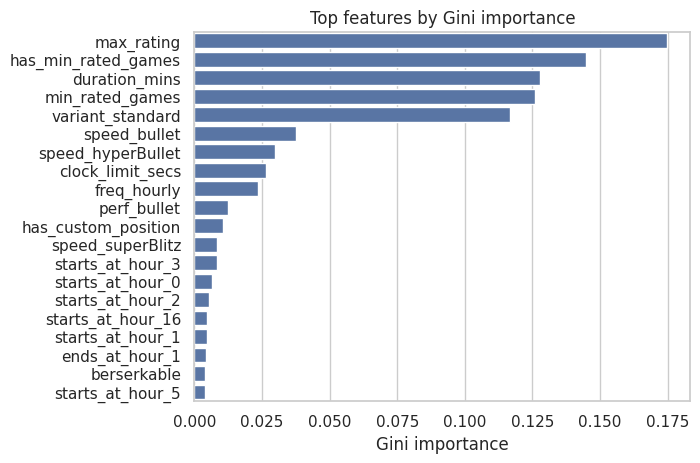

In [5]:
gini_importances = pd.Series(
    pipeline[-1].regressor_.feature_importances_,
    index=pipeline[:-1].get_feature_names_out(X_train.columns)
).sort_values(ascending=False)

fig, ax = plt.subplots()
sns.barplot(gini_importances[:20], orient="h", ax=ax)
ax.set_xlabel("Gini importance")
ax.set_title("Top features by Gini importance");

### Permutation importance

How much randomly shuffling the values of each feature changes the value of the scoring metric ($R^2$ in my case).

For categorical features, the shuffling happens before the one-hot encoding, so the importance is computed once per feature and not for each possible value.

https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html

In [6]:
pi_result = sklearn.inspection.permutation_importance(pipeline, X_train, y_train, random_state=27)

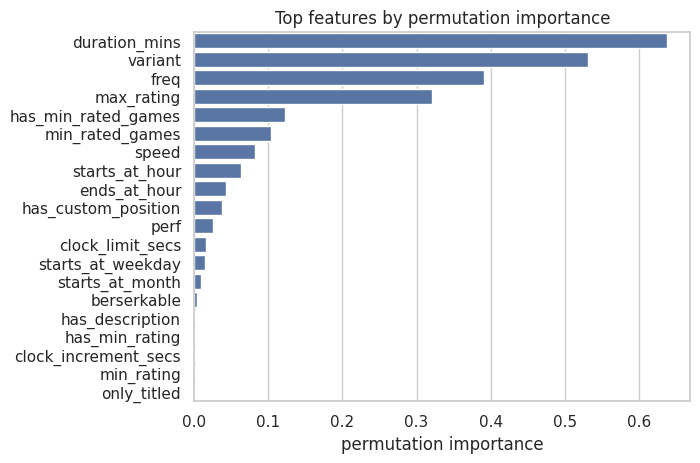

In [7]:
perm_importances = pd.Series(pi_result.importances_mean, index=X_train.columns).sort_values(ascending=False)

fig, ax = plt.subplots()
sns.barplot(perm_importances[:20], orient="h", ax=ax)
ax.set_xlim(left=0)
ax.set_xlabel("permutation importance")
ax.set_title("Top features by permutation importance");

## Local feature importance

Feature importance measured for specific samples.

### LIME

Builds a linear model approximating our model in the vicinity of a sample by perturbing each feature and observing the changes in our model's output.

LIME has native support for categorical features, but they have to be encoded as integers.
In my project this is handled in `preprocessing.LimeWrapper`.

https://github.com/marcotcr/lime

In [8]:
lime_wrapper = preprocessing.LimeWrapper(X_train)

In [9]:
# Explains a prediction from the test set
def show_explanation(idx):
    one_row_df = X_test.iloc[idx:idx + 1]
    explanation = lime_wrapper.explain_instance(
        pipeline, one_row_df, num_features=20, num_samples=100000
    )

    starts_at = datetime.datetime.fromisoformat(one_row_df.starts_at.iloc[0]).strftime("%b %e %Y %H:%M")
    print(f"\n{one_row_df.name.iloc[0]}, {starts_at}")
    print(f"Predicted attendance: {round(pipeline.predict(one_row_df)[0])} players")
    print(f"True attendance: {y_test.iloc[idx]} players")
    explanation.show_in_notebook(show_table=True, show_predicted_value=False)

In [10]:
show_explanation(0)


≤1300 SuperBlitz Arena, Aug 24 2023 21:01
Predicted attendance: 81 players
True attendance: 114 players


In [11]:
show_explanation(4)


Hourly UltraBullet Arena, Apr 17 2024 09:30
Predicted attendance: 100 players
True attendance: 105 players


In [12]:
show_explanation(31)


Racing Kings Shield Arena, Aug 21 2024 16:00
Predicted attendance: 281 players
True attendance: 226 players


In [13]:
show_explanation(1060)


Daily Rapid Arena, Sep  9 2024 19:00
Predicted attendance: 1540 players
True attendance: 1540 players
